### **DeepLOB-Seq2Seq**

In [ ]:
# load packages

import numpy as np
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **Data**
The dataset in the folder Dataset is the FI-2010 dataset zipped and normalized.

As in the original paper I used the firs 7 days to train and to validate (80% / 20%), and the rest 3 days to do the the testing.

In [ ]:
# please change the data_path to your local path and unzip the file

dec_data = np.loadtxt('/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

dec_test1 = np.loadtxt('/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

horizon = 5        

y_train = dec_train[-horizon:, :].T
y_val = dec_val[-horizon:, :].T
y_test = dec_test[-horizon:, :].T

y_train = y_train[49:] - 1
y_val = y_val[49:] - 1
y_test = y_test[49:] - 1 

dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

In [ ]:
def get_label(data):
  
    all_label = []
    
    for i in range(data.shape[1]):
        one_label = data[:, i]
        one_label = keras.utils.to_categorical(one_label, 3)
        one_label = one_label.reshape(len(one_label), 1, 3)
        all_label.append(one_label)

    return np.hstack(all_label)


class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, decoder_input ,num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = get_label(y)
        self.decoder_input = decoder_input
        self.length = x.shape[0] - T -self.dim + 1
        print(self.y.shape)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(self.y).float()

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 0, 2)
        
        return input, self.y[i], self.decoder_input[i]

In [ ]:
#Hyperparameters

batch_size = 32
epochs = 100
T = 10      
num_classes = 3
dim = 50

decoder_input_train = torch.zeros(dec_train.shape[0] - dim + 1, 1, 3)
decoder_input_train[:, 0, 0] = 1

decoder_input_val = torch.zeros(dec_val.shape[0] - dim + 1, 1, 3)
decoder_input_val[:, 0, 0] = 1

decoder_input_test = torch.zeros(dec_test.shape[0] - dim + 1, 1, 3)
decoder_input_test[:, 0, 0] = 1

dataset_val = Dataset(dec_val, y_val, decoder_input_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, decoder_input_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, decoder_input_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

(50901, 5, 3)
(139538, 5, 3)
(203751, 5, 3)


### **Model Architecture**
The Architecture is described in the paper

In [ ]:
class DeepLOB_Seq2Seq(nn.Module):
  def __init__(self):
    super().__init__()
    # convolution blocks
    # convolution blocks
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
    )
    
    # inception moduels
    self.inp1 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
    )
    self.inp2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
    )
    self.inp3 = nn.Sequential(
        nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
        nn.LeakyReLU(negative_slope=0.01),
    )
    
    # lstm layers
    self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
    
    self.decoder_lstm = nn.LSTM(input_size=67, hidden_size=64, num_layers=1, batch_first=True)
    self.fc1 = nn.Linear(128, 3)

  def forward(self, x, decoder_inputs):  

    h0 = torch.zeros(1, x.size(0), 64).to(device)
    c0 = torch.zeros(1, x.size(0), 64).to(device)

    x = self.conv1(x)

    x = self.conv2(x)

    x = self.conv3(x)

    x_inp1 = self.inp1(x)
    x_inp2 = self.inp2(x)
    x_inp3 = self.inp3(x) 

    x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
   
    x = x.permute(0, 2, 1, 3)

    x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
    
    x, (h0, c0) = self.lstm(x, (h0, c0))
   
    encoder_outputs = x[:, -1, :]  #we take only the last output of the encoder to form the context vector     
    
    states = (h0, c0)
    
    encoder_outputs = torch.reshape(encoder_outputs, (encoder_outputs.shape[0], 1, encoder_outputs.shape[1])).to(device)

    inputs = torch.concatenate([decoder_inputs, encoder_outputs], axis=2)

    all_outputs = torch.zeros(5, x.shape[0], 3).to(device)

    #we iterate for every horizon (10, 20, 30, 50, 100)
    for i in range(5):

      #we pass in input to the decoder the context vector, the last decoder's output and the last decoder's hidden state 
      h_t, (state_h, state_c) = self.decoder_lstm(inputs, states)
      
      #creating the input to compute the distribution for the output (3)
      last_inputs = torch.concatenate([h_t, encoder_outputs],  axis=2)

      #computing the distribution for the output with the context vector (encoder_outputs) and the decoder's output
      output = self.fc1(last_inputs)

      output = torch.softmax(output, dim=2)

      all_outputs[i] = torch.squeeze(output)
      inputs = torch.concatenate([output, encoder_outputs], axis=2)
      states = [state_h, state_c]
    
    all_outputs = torch.permute(all_outputs, (1, 2, 0))
    return all_outputs

### **Model Training**

In [ ]:
model = DeepLOB_Seq2Seq()
model.to(device)
lr = 0.001
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr, eps=1e-07)

def batch_gd(model, criterion, optimizer, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    i = 0
    cont = 0
    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets, decoder_inputs in train_loader:
            # move data to GPU
            targets = torch.permute(targets, (0, 2, 1))
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)
            decoder_inputs = decoder_inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, decoder_inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss)
    
        model.eval()
        test_loss = []
        for inputs, targets, decoder_inputs in val_loader:
            targets = torch.permute(targets, (0, 2, 1))
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)    
            decoder_inputs = decoder_inputs.to(device)  
            outputs = model(inputs, decoder_inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, '/best_model_seq2seq')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        
    return train_losses, test_losses

In [ ]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

train_losses, val_losses = batch_gd(model, criterion, optimizer, epochs=50)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

------- List Hyper Parameters -------
epochs   ->   100
horizon    ->     10
batch size   ->    32
Optimizer   ->    Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-07
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,
  2%|▏         | 1/50 [02:11<1:47:40, 131.84s/it]

model saved
Epoch 1/50, Train Loss: 0.9502,           Validation Loss: 0.9171, Duration: 0:02:11.841779, Best Val Epoch: 0


  4%|▍         | 2/50 [04:11<1:39:41, 124.62s/it]

model saved
Epoch 2/50, Train Loss: 0.8397,           Validation Loss: 0.8784, Duration: 0:01:59.560732, Best Val Epoch: 1


  6%|▌         | 3/50 [06:10<1:35:40, 122.14s/it]

model saved
Epoch 3/50, Train Loss: 0.8185,           Validation Loss: 0.8699, Duration: 0:01:59.176344, Best Val Epoch: 2


  8%|▊         | 4/50 [08:10<1:32:52, 121.13s/it]

model saved
Epoch 4/50, Train Loss: 0.8098,           Validation Loss: 0.8696, Duration: 0:01:59.595555, Best Val Epoch: 3


 10%|█         | 5/50 [10:08<1:30:12, 120.28s/it]

Epoch 5/50, Train Loss: 0.8062,           Validation Loss: 0.8737, Duration: 0:01:58.766225, Best Val Epoch: 3


 12%|█▏        | 6/50 [12:08<1:27:54, 119.87s/it]

model saved
Epoch 6/50, Train Loss: 0.8039,           Validation Loss: 0.8658, Duration: 0:01:59.070847, Best Val Epoch: 5


 14%|█▍        | 7/50 [14:07<1:25:55, 119.89s/it]

model saved
Epoch 7/50, Train Loss: 0.8136,           Validation Loss: 0.8632, Duration: 0:01:59.942842, Best Val Epoch: 6


 16%|█▌        | 8/50 [16:05<1:23:28, 119.24s/it]

Epoch 8/50, Train Loss: 0.8242,           Validation Loss: 0.8792, Duration: 0:01:57.838662, Best Val Epoch: 6


 18%|█▊        | 9/50 [18:03<1:21:14, 118.90s/it]

Epoch 9/50, Train Loss: 0.8439,           Validation Loss: 0.8940, Duration: 0:01:58.153022, Best Val Epoch: 6


 20%|██        | 10/50 [20:03<1:19:24, 119.10s/it]

Epoch 10/50, Train Loss: 0.8459,           Validation Loss: 0.9271, Duration: 0:01:59.553916, Best Val Epoch: 6


 22%|██▏       | 11/50 [22:01<1:17:15, 118.86s/it]

Epoch 11/50, Train Loss: 0.9159,           Validation Loss: 0.9936, Duration: 0:01:58.294539, Best Val Epoch: 6


 24%|██▍       | 12/50 [23:59<1:15:07, 118.61s/it]

Epoch 12/50, Train Loss: 0.9490,           Validation Loss: 0.9617, Duration: 0:01:58.037127, Best Val Epoch: 6


 26%|██▌       | 13/50 [25:59<1:13:18, 118.89s/it]

Epoch 13/50, Train Loss: 0.9918,           Validation Loss: 1.0050, Duration: 0:01:59.532530, Best Val Epoch: 6


 28%|██▊       | 14/50 [27:58<1:11:23, 119.00s/it]

Epoch 14/50, Train Loss: 0.9967,           Validation Loss: 1.0403, Duration: 0:01:59.240718, Best Val Epoch: 6


 30%|███       | 15/50 [29:58<1:09:32, 119.23s/it]

Epoch 15/50, Train Loss: 1.0354,           Validation Loss: 1.0396, Duration: 0:01:59.764571, Best Val Epoch: 6


 30%|███       | 15/50 [31:36<1:13:46, 126.46s/it]


KeyboardInterrupt: ignored

### **Model Testing**

In [ ]:
model = torch.load('/best_model_seq2seq')

n_correct = 0.
n_total = 0.
all_targets = [[], [], [], [], []]
all_predictions = [[], [], [], [], []]
cont = 0
for inputs, targets, decoder_inputs in test_loader:
    # Move to GPU
    targets = torch.permute(targets, (0, 2, 1))
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)    
    decoder_inputs = decoder_inputs.to(device)
    cont += 1
    
    # Forward pass
    outputs = model(inputs, decoder_inputs)

    #Get prediction
    _, predictions = torch.max(outputs, 1)
    _, targets = torch.max(targets, 1)
    for i in range(5):
      prediction = predictions[:, i]
      target = targets[:, i]

      if (cont == 1):
        all_targets[i] = target.cpu().numpy()
        all_predictions[i] = prediction.cpu().numpy()
        
      else:
        all_targets[i] = np.concatenate((all_targets[i], target.cpu().numpy()))
        all_predictions[i] = np.concatenate((all_predictions[i], prediction.cpu().numpy()))

              precision    recall  f1-score   support

           0     0.7255    0.5151    0.6025     21147
           1     0.8457    0.9547    0.8969     98614
           2     0.7477    0.4988    0.5984     19767

    accuracy                         0.8235    139528
   macro avg     0.7730    0.6562    0.6993    139528
weighted avg     0.8136    0.8235    0.8100    139528



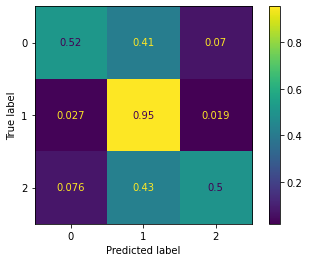

              precision    recall  f1-score   support

           0     0.6529    0.4586    0.5388     27448
           1     0.7698    0.9217    0.8389     86595
           2     0.6754    0.4390    0.5321     25485

    accuracy                         0.7424    139528
   macro avg     0.6994    0.6064    0.6366    139528
weighted avg     0.7295    0.7424    0.7238    139528



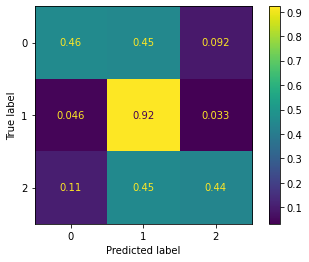

              precision    recall  f1-score   support

           0     0.6947    0.6008    0.6443     31915
           1     0.7956    0.8949    0.8423     78297
           2     0.7046    0.5733    0.6322     29316

    accuracy                         0.7601    139528
   macro avg     0.7316    0.6897    0.7063    139528
weighted avg     0.7534    0.7601    0.7529    139528



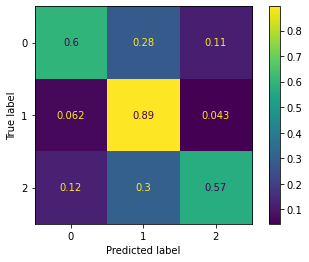

              precision    recall  f1-score   support

           0     0.7327    0.6769    0.7037     38439
           1     0.8207    0.8669    0.8431     65990
           2     0.6990    0.6833    0.6911     35099

    accuracy                         0.7684    139528
   macro avg     0.7508    0.7424    0.7460    139528
weighted avg     0.7658    0.7684    0.7665    139528



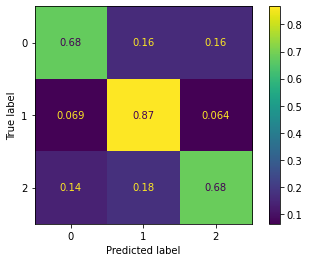

              precision    recall  f1-score   support

           0     0.7442    0.7364    0.7403     47952
           1     0.8699    0.7910    0.8286     48040
           2     0.6871    0.7638    0.7234     43536

    accuracy                         0.7638    139528
   macro avg     0.7671    0.7637    0.7641    139528
weighted avg     0.7697    0.7638    0.7654    139528



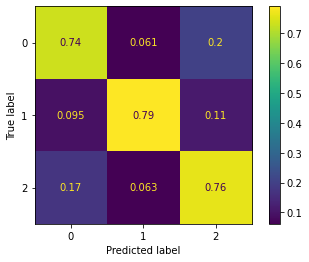

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

for i in range(5):
  print(classification_report(all_targets[i], all_predictions[i], digits=4))
  c = confusion_matrix(all_targets[i], all_predictions[i], normalize="true")
  disp = ConfusionMatrixDisplay(c)
  disp.plot()
  plt.show()